In [57]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.model_selection import train_test_split

In [58]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['ADBE', 'MSFT' ]

df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2018-12-24,205.160004,94.129997
2018-12-26,222.949997,100.559998
2018-12-27,225.139999,101.180000
2018-12-28,223.130005,100.389999
2018-12-31,226.240005,101.570000


In [59]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

np.float64(0.04452696271616793)

In [60]:
ratios = df['ADBE'] / df['MSFT']
print(len(ratios) )
df['ratios'] =ratios 
print(df['ratios'][0:1057])

1510
Date
2013-01-02    1.388125
2013-01-03    1.385321
2013-01-04    1.425954
2013-01-07    1.421506
2013-01-08    1.436535
                ...   
2017-03-08    1.840283
2017-03-09    1.852464
2017-03-10    1.864931
2017-03-13    1.882244
2017-03-14    1.885421
Name: ratios, Length: 1057, dtype: float64


In [61]:
df['mavg5'] = df['ratios'].rolling(window=5, center=False).mean()
df['mavg60'] = df['ratios'].rolling(window=60, center=False).mean()
df['mavg20'] = df['ratios'].rolling(window=20, center=False).mean()
df['std20'] = df['ratios'].rolling(window=20, center=False).std()
df['std5'] = df['ratios'].rolling(window=5, center=False).std()
df['std60'] = df['ratios'].rolling(window=60, center=False).std()


df['ratio_lag1'] = df['ratios'].shift(1)
df['ratio_lag2'] = df['ratios'].shift(2)
df['roc5'] = df['ratios'].pct_change(periods=5)
df['roc60'] = df['ratios'].pct_change(periods=60)
df['roc20'] = df['ratios'].pct_change(periods=20)
df.dropna()
features= ['roc5','roc20','roc60','mavg5', 'mavg20', 'mavg60', 'std20', 'ratio_lag1', 'ratio_lag2']
X=df[features]
y=df['ratios']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)


Mean Squared Error: 0.0018234484230771602
Mean Absolute Error: 0.03301549008742426


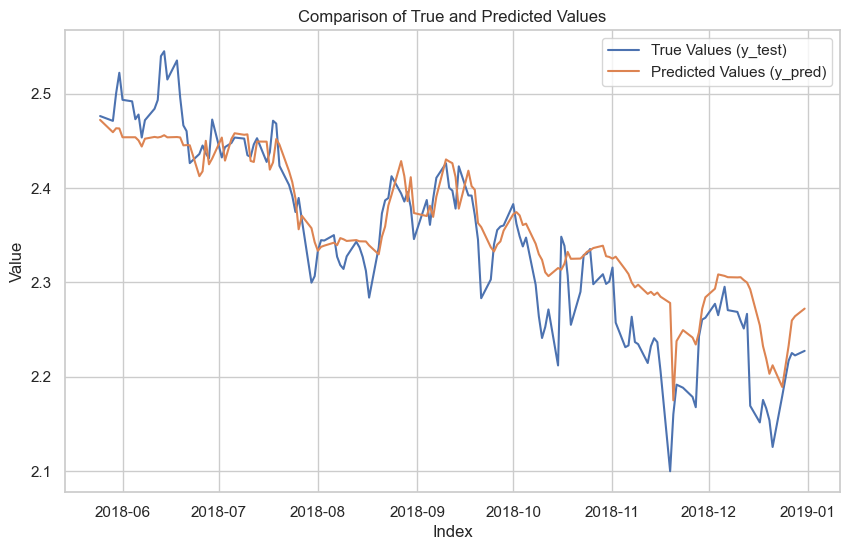

151


In [62]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="True Values (y_test)")
plt.plot(y_test.index, y_pred, label="Predicted Values (y_pred)")

plt.title("Comparison of True and Predicted Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

print(len(y_pred))

In [79]:
def trade (df2,mae):
    S1=0
    S2=0
    for i in range(len(df2['Predicted_Ratio'])):
        if df2['Predicted_Ratio'][i] > df2['ADBE'][i]/df2['MSFT'][i] + mae / 5:
            S1=S1+1
            S2=S2-1
        elif df2['Predicted_Ratio'][i] + mae / 5 < df2['ADBE'][i]/df2['MSFT'][i]:
            S1=S1-1
            S2=S2+1
        df2['PNL'][i]=S1*df2['ADBE'][i]+S2*df2['MSFT'][i]
    


In [ ]:
df2 = pd.DataFrame()
df2['Predicted_Ratio']=y_pred
for i in range(151):
    df2.loc[i, 'ADBE'] = df['ADBE'].iloc[-151 + i] 
    df2.loc[i, 'MSFT'] = df['MSFT'].iloc[-151 + i]  
df2['PNL']=0
print(df2)
trade(df2,mae)




     Predicted_Ratio        ADBE        MSFT  PNL
0           2.472122  243.559998   98.360001    0
1           2.459107  242.190002   98.010002    0
2           2.463255  247.399994   98.949997    0
3           2.463061  249.279999   98.839996    0
4           2.453735  251.309998  100.790001    0
..               ...         ...         ...  ...
146         2.189151  205.160004   94.129997    0
147         2.233000  222.949997  100.559998    0
148         2.259635  225.139999  101.180000    0
149         2.264137  223.130005  100.389999    0
150         2.272196  226.240005  101.570000    0

[151 rows x 4 columns]


0         0.000000
1      -144.180000
2      -296.899994
3      -451.320007
4      -602.079987
          ...     
146    4330.170250
147    4895.599976
148    5082.359962
149    5155.080231
150    5360.810249
Name: PNL, Length: 151, dtype: float64


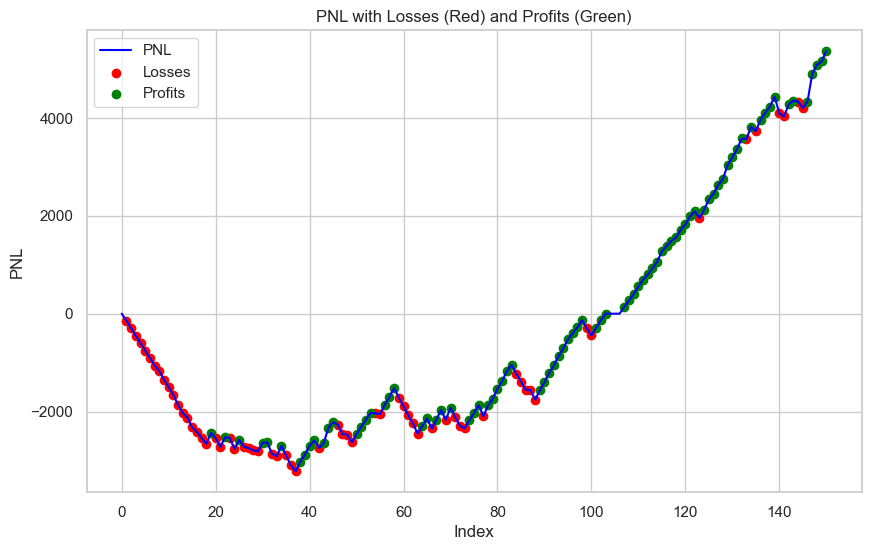

In [85]:
print(df2['PNL'])
df2['PNL_change']=df2['PNL'].diff()
# Assuming df2 is already defined and contains the 'PNL' column
df2['PNL_change'] = df2['PNL'].diff()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the PNL values
plt.plot(df2['PNL'], label='PNL', color='blue')

# Highlight losses (negative PNL change) in red and profits (positive PNL change) in green
plt.scatter(df2.index[df2['PNL_change'] < 0], df2['PNL'][df2['PNL_change'] < 0], color='red', label='Losses')
plt.scatter(df2.index[df2['PNL_change'] > 0], df2['PNL'][df2['PNL_change'] > 0], color='green', label='Profits')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('PNL')
plt.title('PNL with Losses (Red) and Profits (Green)')

# Show the legend
plt.legend()

# Show the plot
plt.show()